In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import (
    InputLayer, Conv2D, MaxPooling2D, Flatten,
    Dense, Reshape, Conv2DTranspose, Input
)
from keras.preprocessing.image import ImageDataGenerator
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from keras.layers import BatchNormalization, Dropout

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
main_folder_path = "/kaggle/input/cropped-faces/cropped_faces"

# Image Preprocessing

In [3]:
X = []
y = []

for folder in os.listdir(main_folder_path):
    category_path = os.path.join(main_folder_path, folder)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (256, 256))
#         print(img.shape)
        
        X.append(img)
        y.append(folder)

In [4]:
# Convert the list of strings to a NumPy array of strings
y = np.array(y, dtype='str')

# Now, 'string_array' is a NumPy array containing strings.

In [5]:
X = np.array(X)
X.shape

(734, 256, 256)

# Splitting into Train and Test

In [6]:
np.random.seed(1)
tf.random.set_seed(1)
X = np.expand_dims(X, axis=3)
print('Shape of X : {}, Shape of y : {}'.format(X.shape, y.shape))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Shape of X : (734, 256, 256, 1), Shape of y : (734,)


# Displaying the input Images

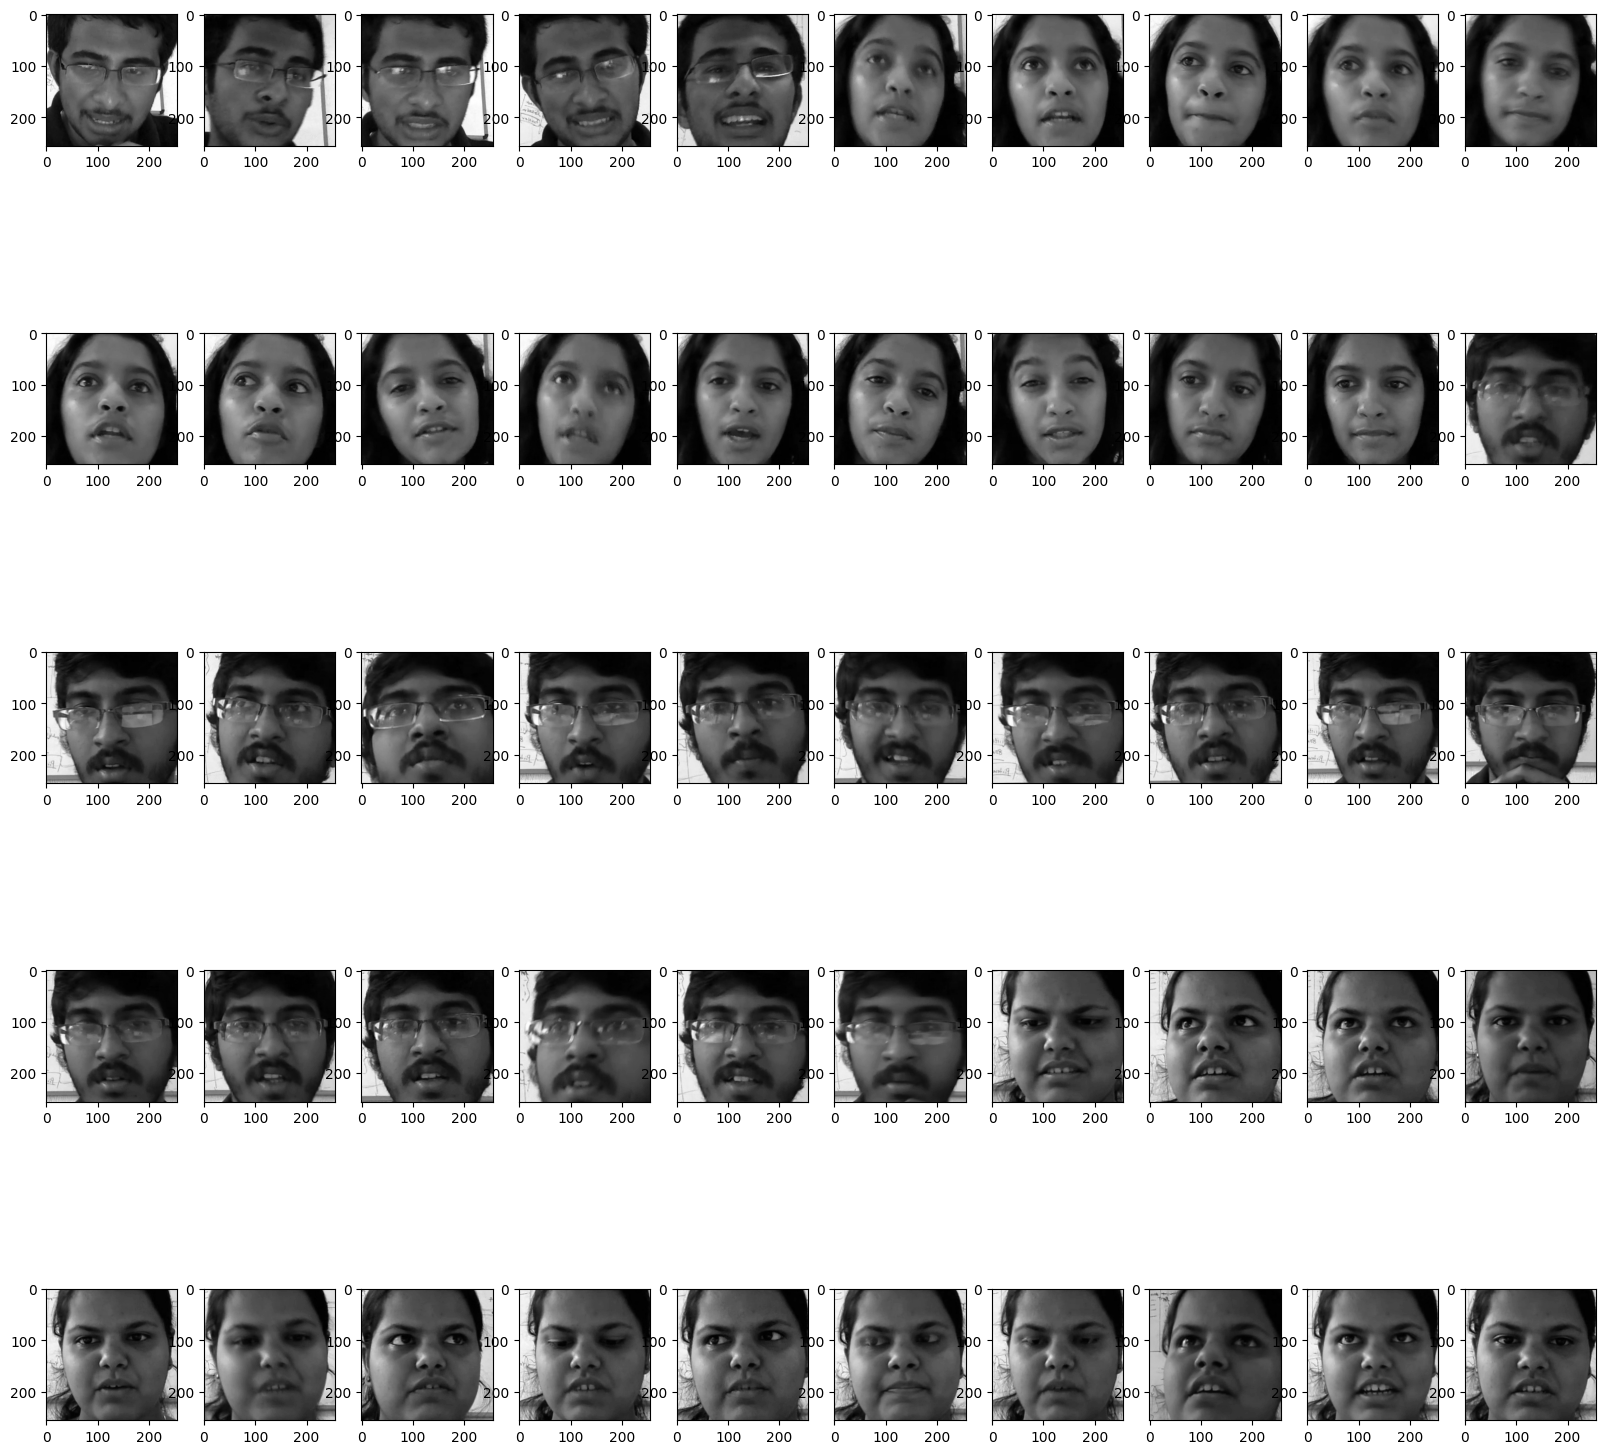

In [7]:
fig=plt.figure(figsize=(20, 20))
for i in range(5):
    for j in range(10 * i, 10 * (i + 1)):
        fig.add_subplot(5, 10, j + 1)
        plt.imshow(X[j].squeeze(), cmap='gray')
plt.show()

# Autoencoder

In [9]:
def autoencoder(img_size, code_size):
    encoder = Sequential()
    encoder.add(InputLayer(img_size))
    encoder.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                       activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    encoder.add(BatchNormalization())  # Add batch normalization
    encoder.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                       activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    encoder.add(BatchNormalization())  # Add batch normalization
    encoder.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same',
                       activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    encoder.add(BatchNormalization())  # Add batch normalization
    encoder.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same',
                       activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    encoder.add(BatchNormalization())  # Add batch normalization
    encoder.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same',
                       activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    encoder.add(BatchNormalization())  # Add batch normalization
    encoder.add(Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), padding='same',
                       activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    encoder.add(BatchNormalization())  # Add batch normalization
    encoder.add(Flatten())
    encoder.add(Dropout(0.5))  # Add dropout layer
    encoder.add(Dense(units=code_size))
    
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(units=4 * 4 * 1024))
    decoder.add(Reshape((4, 4, 1024)))
    decoder.add(Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                activation='relu'))
    decoder.add(Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                activation='relu'))
    decoder.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                activation='relu'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                activation='relu'))
    decoder.add(Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                activation='relu'))
    
    return encoder, decoder

# Autoencoder Architecture

In [10]:
encoder, decoder = autoencoder(X[0].shape, 200)
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                        

# Training Autoencoder

In [11]:
inp = Input(X[0].shape)
autoencoder = Model(inputs=inp, outputs=decoder(encoder(inp)))
autoencoder.compile(optimizer='adam', loss='mse')

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, 
                            horizontal_flip=True)
datagen.fit(X_train)
batch_size=32
autoencoder.fit_generator(datagen.flow(X_train, X_train, batch_size=batch_size), steps_per_epoch =
                          len(X_train) // batch_size, epochs=200, validation_data=(X_test, X_test))

Epoch 1/200


/tmp/ipykernel_28/2795889267.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  autoencoder.fit_generator(datagen.flow(X_train, X_train, batch_size=batch_size), steps_per_epoch =


16/16 [==============================] - 24s 319ms/step - loss: 10771.0850 - val_loss: 10367.9424
Epoch 2/200
16/16 [==============================] - 2s 135ms/step - loss: 7465.9956 - val_loss: 104093.0703
Epoch 3/200
16/16 [==============================] - 2s 130ms/step - loss: 3904.1626 - val_loss: 25588990.0000
Epoch 4/200
16/16 [==============================] - 2s 130ms/step - loss: 2743.8093 - val_loss: 36635856.0000
Epoch 5/200
16/16 [==============================] - 2s 134ms/step - loss: 2245.6033 - val_loss: 13331156.0000
Epoch 6/200
16/16 [==============================] - 2s 140ms/step - loss: 2320.4844 - val_loss: 12499736.0000
Epoch 7/200
16/16 [==============================] - 2s 131ms/step - loss: 1990.6731 - val_loss: 29213288.0000
Epoch 8/200
16/16 [==============================] - 2s 132ms/step - loss: 1888.9058 - val_loss: 42410108.0000
Epoch 9/200
16/16 [==============================] - 2s 140ms/step - loss: 2028.0488 - val_loss: 18787844.0000
Epoch 10/200
16/

In [12]:
def normalize(X, mean, std):
    return (X - mean) / (std + epsilon())

# Displaying Reconstructed Images

7/7 [==============================] - 1s 40ms/step


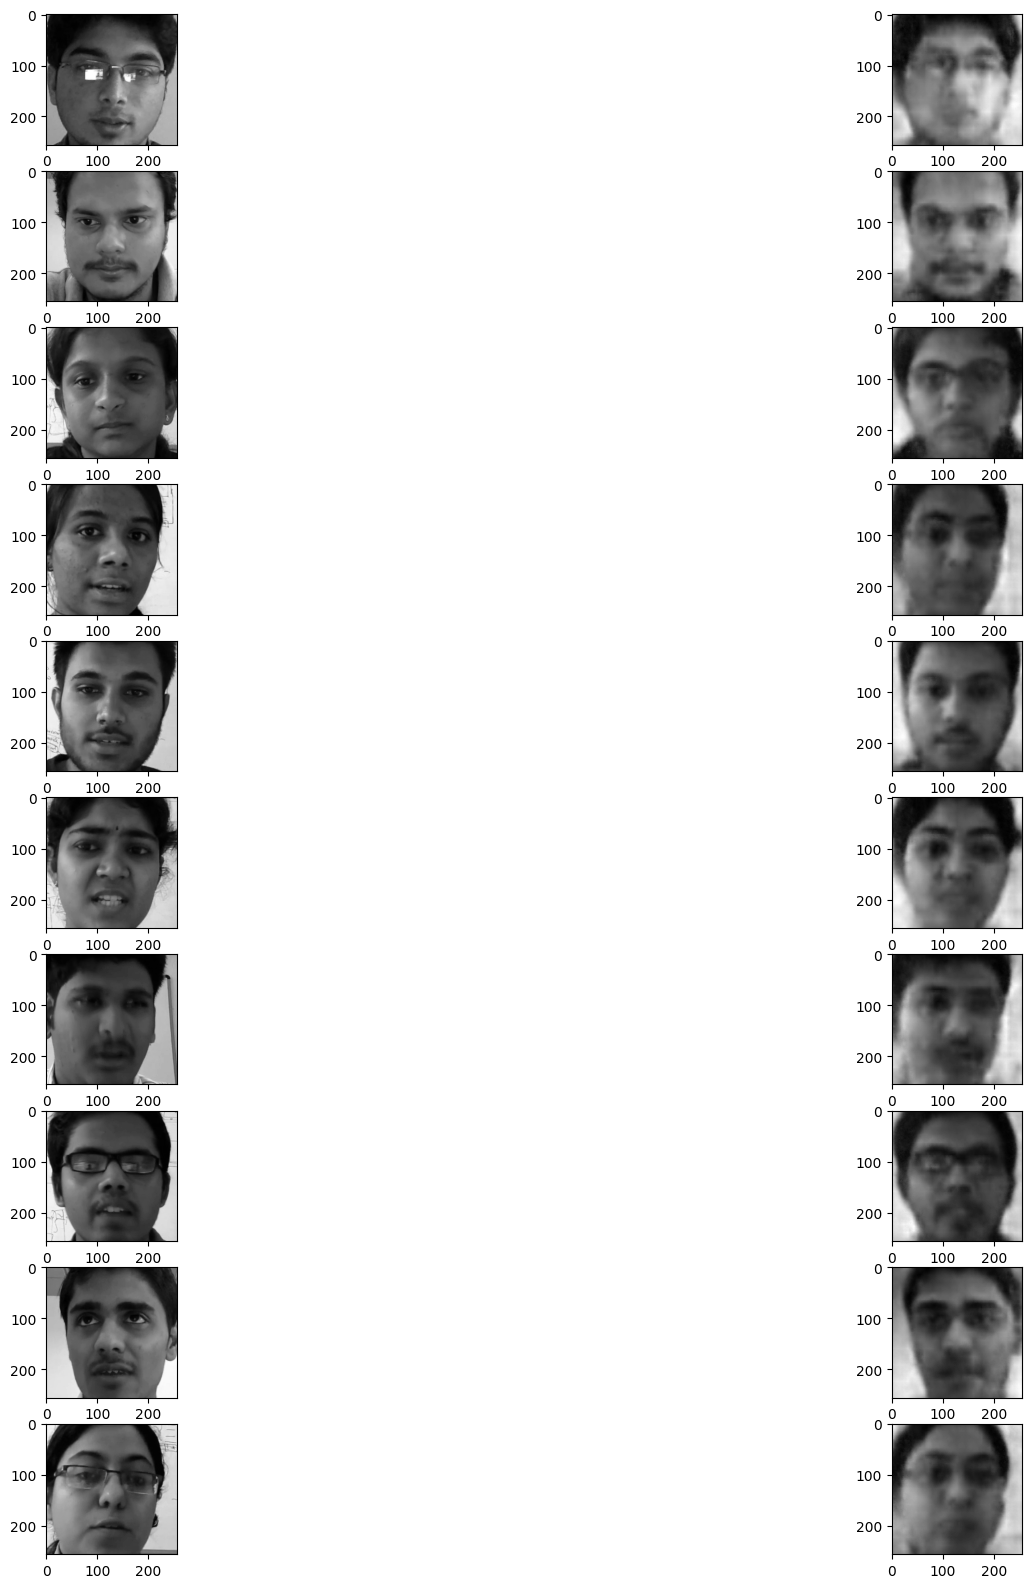

In [13]:
reconstructed = autoencoder.predict(normalize(X_test, datagen.mean, datagen.std))
fig=plt.figure(figsize=(20, 20))
for i in range(1, 11):
    fig.add_subplot(10, 2, 2 * i - 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    fig.add_subplot(10, 2, 2 * i)
    plt.imshow(reconstructed[i].squeeze(), cmap='gray')
plt.show()

# Calculating Accuracy

In [14]:
classifier = KNeighborsClassifier(n_neighbors=3, weights='distance')
classifier.fit(encoder.predict(normalize(X_train, datagen.mean, datagen.std)), y_train)
print('Test set accuracy : {}%'.format(classifier.score(encoder.predict(normalize(
    X_test, datagen.mean, datagen.std)), y_test) * 100))

7/7 [==============================] - 0s 19ms/step
Test set accuracy : 92.76018099547511%
